# Ethno

This notebook is a global template for loading and preprocess data.

## What is the SVM algorithm?

 It is a supervised learning algorithm designed to solve discrimination and regression problems.
 
 It is a very good image classification algorithm.
 
 ![enter image description here](https://editor.analyticsvidhya.com/uploads/61706svm3.png)
 
 ## Summary
 
 1. [Data preparation](#prepaData)
 2. [Learning of model](#model)
 3. [Displaying metrics](#metric)
 4. [Conclusion](#conclusion)

### 1. Data preparation <a id="prepaData"></a>
 
 - To start, we import the necessary libraries.

In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
import time
import itertools
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, Dropout, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 - We define all necessary variables.

In [190]:
import pathlib
path = ''
train_path = ''
test_path = ''
val_path = ''
IMG_SIZE = 100
scale = 1
batch_size = 10
nb_train_samples = 100
nb_validation_samples = 100
epochs = 10
labels = ['Pigeon_Guillemot', 'Red_headed_Woodpecker']




## Get trainning data

In [191]:
def get_training_data(data_dir, size):
    data = list()
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for image in os.listdir(path):
            if(image != ".DS_Store"):
                try:
                    image_arr = cv2.imread(os.path.join(
                        path, image), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(image_arr, (size, size))
                    data.append([resized_arr, class_num])
                except Exception as e:
                    print(e)
    return np.array(data, dtype="object")


In [192]:
test = get_training_data(test_path, IMG_SIZE)
train = get_training_data(train_path, IMG_SIZE)
val = get_training_data(val_path, IMG_SIZE)

## Balance dataset


In [193]:
def mix_datasets(array):
    # Pneumonie
    arr_1 = array[np.where(array[:, 1] == 1)]
    # Normal
    arr_0 = array[np.where(array[:, 1] == 0)]
    l_arr_1 = len(arr_1)
    l_arr_0 = len(arr_0)
    diff = 0

    if l_arr_0 > l_arr_1:
        diff = l_arr_0 - l_arr_1
        arr_0.resize((l_arr_0 - diff, arr_0.shape[1]))
        array = np.concatenate((l_arr_0, arr_1))
    else:
        diff = l_arr_1 - l_arr_0
        arr_1.resize((l_arr_1 - diff, arr_1.shape[1]))
        array = np.concatenate((arr_0, arr_1))
    return array

## Scaling datasets

In [194]:
train_scaled = train[np.random.randint(
    train.shape[0], size=int(len(train)*scale)), :]
test_scaled = test[np.random.randint(
    test.shape[0], size=int(len(test)*scale)), :]

## Preparing datasets

In [195]:
def prepare_dataset(dataset):
    X_ = list()
    y_ = list()
    for features, label in dataset:
        X_.append(features)
        y_.append(label)
    X_ = np.array(X_)
    X_ = X_.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    y_ = np.array(y_)
    return X_, y_

In [196]:
x_train, label_train = prepare_dataset(mix_datasets(train))
x_test, label_test = prepare_dataset(mix_datasets(test))
x_val, label_val = prepare_dataset(mix_datasets(val))

In [197]:
# Append train + test + val data in order to scale our datasets
X = np.concatenate((x_train, x_test))
X = np.concatenate((X, x_val))
Y = np.concatenate((label_train, label_test))
Y = np.concatenate((Y, label_val))

In [198]:
# Hold-Out cross validation
# test_size: what proportion of original data is used for test set 
x_train, x_test, label_train, label_test = train_test_split( X, Y, test_size=0.30)

Normalize Data

In [199]:
xmax = np.array(x_train).max()
x_train = x_train / xmax
xmax = np.array(x_test).max()
x_test = x_test / xmax

### 2. Learning of model <a id="model"></a>

In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
          input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(120))
model.add(layers.Dense(2, activation='softmax'))

## Init training's Callback

In [201]:
def callbacks():
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='lstmchar256256128test.h5',
            monitor='loss',
            save_best_only=True
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=0,
            patience=4,
            mode='auto',
            baseline=None,
        )
    ]
    return callbacks

In [202]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 21, 21, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 10, 10, 64)     

In [203]:
y_test = np.array(label_test)
y_train = np.array(label_train)

In [204]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

time1 = time.time()
history = model.fit(x_train, y_train, epochs=10, validation_data=(
    x_test, y_test), callbacks=callbacks())

# Print duration time
duration_time = time.time() - time1
if duration_time < 60:
    print("{} s".format(duration_time))
else:
    print("{} min".format(duration_time/60))

Epoch 1/10


/Users/guixax/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 1s 227ms/step - loss: 0.7108 - accuracy: 0.4833 - val_loss: 0.7081 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 1s 189ms/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6858 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 1s 189ms/step - loss: 0.6853 - accuracy: 0.5167 - val_loss: 0.6806 - val_accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 1s 189ms/step - loss: 0.6779 - accuracy: 0.5583 - val_loss: 0.6708 - val_accuracy: 0.6538
Epoch 5/10
4/4 [==============================] - 1s 214ms/step - loss: 0.6633 - accuracy: 0.6333 - val_loss: 0.6433 - val_accuracy: 0.7885
Epoch 6/10
4/4 [==============================] - 1s 235ms/step - loss: 0.6281 - accuracy: 0.6917 - val_loss: 0.6053 - val_accuracy: 0.8462
Epoch 7/10
4/4 [==============================] - 1s 275ms/step - loss: 0.5583 - accuracy: 0.8250 - val_loss: 0.5164 - val_accuracy: 0.8077
Epoch 8/10
4/4 [===============

# 3. Displaying metrics <a id="metric"></a>

## loss + accuracy graph

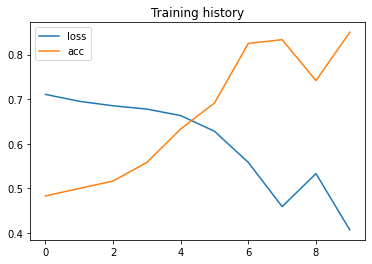

In [205]:
import matplotlib.pyplot as plt

history_loss = history.history["loss"]
history_acc = history.history["accuracy"]

plt.plot(history_loss, label="loss")
plt.plot(history_acc, label="acc")
plt.title("Training history")
plt.legend()


## Prediction

In [206]:
pred = model.predict(x_test)


In [207]:
predicted_classes = np.argmax(pred, axis=1)
report = classification_report(predicted_classes, y_test, target_names=labels)
print(report)


                       precision    recall  f1-score   support

     Pigeon_Guillemot       0.77      0.87      0.82        23
Red_headed_Woodpecker       0.88      0.79      0.84        29

             accuracy                           0.83        52
            macro avg       0.83      0.83      0.83        52
         weighted avg       0.83      0.83      0.83        52



We can see that our model obtains 65% precision for the guillemot pigeon against 72% for the Red headed woodpecker

### Cunsion Mactix

In [208]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [209]:
cm = confusion_matrix(y_true=label_test, y_pred=predicted_classes)


Confusion matrix, without normalization
[[20  6]
 [ 3 23]]


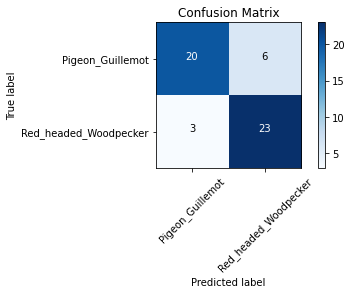

In [210]:
plot_confusion_matrix(cm=cm, classes=labels, title='Confusion Matrix')


In [211]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')


Test loss     : 0.3912
Test accuracy : 0.8269


# conclusion <a id="conclusion"></a>

Based on the confusion matrix, we obtain an accuracy of 82% for the guillemot pigeon with a few proportion of false negatives , as well as an accuracy of 84% for the Red headed woodpecker with a small amount of false positive.

The cause of this discrepancy in accuracy can be due to several things such as an uneven distribution of our starting dataset with one class more present than the other.